# Anomoly Detection for Supermarket Refrigeration System

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stat
import scipy.signal
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

## Read data

In [2]:
data = pd.read_excel('/Users/chenbq/Desktop/CMU/Research 101/Vapour Compression/Giant Eagle/0045 interval data.xlsx')
data = data.set_index('Usage date')

In [3]:
temp = pd.read_excel('/Users/chenbq/Desktop/CMU/Research 101/Vapour Compression/Giant Eagle/0045 Environment.xlsx')

temp = temp[temp['Inside temp (F)']!='---']
temp['Inside temp (C)'] = (temp['Inside temp (F)'] - 32)/1.8
temp['Outside temp (C)'] = (temp['Outside temp (F)'] - 32)/1.8

temp = temp.set_index('Usage date')

In [4]:
tmp = pd.merge(temp, data, 'left', left_index = True, right_index = True)
tmp = tmp.dropna(how='any')
tmp = tmp[(tmp['Rack A (kW)']!=0) & (tmp['Rack B (kW)']!=0) & (tmp['Rack C (kW)']!=0) &(tmp['Rack D (kW)']!=0)]

## Fit different models
### Model 1: Regression without dummy
### Model 2: Regression with dummy
### Model 3: ANN with dummy
Use the residue to find anomolies

In [5]:
A1 = tmp[['Outside temp (C)', 'Inside temp (C)']]
A1['Out (K)'] = A1['Outside temp (C)']+273.15
A1['In (K)'] = A1['Inside temp (C)']+273.15
A1['Out2'] = A1['Out (K)']**2
A1['In2'] = A1['In (K)']**2
A1['In*Out'] = A1['In (K)']*A1['Out (K)']
A1['Dummy'] = 1
A1 = A1.drop(['Outside temp (C)', 'Inside temp (C)'], axis=1)

l = ['Rack A (kW)','Rack B (kW)','Rack C (kW)', 'Rack D (kW)']
## Model 2
w1 = np.zeros((6,4))
for i in range(4): 
    Y = tmp[l[i]]
    model = sm.OLS(Y,A1.astype(float), missing = 'drop')
    results = model.fit()
    w1[:,i]=results.params
    Y_pred = pd.Series(results.predict(A1), index = A1.index)
    res = Y-Y_pred
    print(l[i], 'R2: ', results.rsquared, ' MSE: ', (res**2).mean(), ' MAE: ', mean_absolute_error(Y, Y_pred), ' MAPE: ', np.mean(np.abs(Y-Y_pred)/Y))
    # ' AIC: ', results.aic, ' BIC: ', results.bic

Rack A (kW) R2:  0.484277276228  MSE:  11.2390145985  MAE:  2.66141857476  MAPE:  0.0796833522348
Rack B (kW) R2:  0.76604125311  MSE:  14.7138319327  MAE:  2.863515079  MAPE:  0.15618651683
Rack C (kW) R2:  0.833661868007  MSE:  22.2319038337  MAE:  3.77391121827  MAPE:  0.162449304709
Rack D (kW) R2:  0.870914044209  MSE:  4.90033939275  MAE:  1.60413926457  MAPE:  0.0769896499907


In [6]:
# Assign dummies for hour of the day
A2 = pd.DataFrame(0, index=tmp.index, columns=range(24))
for i in range(len(A2)):
    j = int(A2.index[i].hour)
    A2.iloc[i,j]=1
A2 = pd.merge(A2, A1, 'left', left_index = True, right_index = True)

## Model 2
w2 = np.zeros((30,4))
#fig = plt.figure(figsize=(20,40))
for i in range(4): 
    Y = tmp[l[i]]
    X_train, X_test, Y_train, Y_test = train_test_split(A2, Y, test_size=0.33)
    model = sm.OLS(Y_train, X_train.astype(float), missing = 'drop')
    results = model.fit()
    w2[:,i]=results.params
    Y_pred = pd.Series(results.predict(X_test), index = X_test.index)
    res = Y_test - Y_pred
    print(l[i], 'R2: ', results.rsquared, ' MSE: ', (res**2).mean(), ' MAE: ', mean_absolute_error(Y_test, Y_pred), ' MAPE: ', np.mean(np.abs(Y_test-Y_pred)/Y_test))
    #plt.subplot(4,1,i+1)
    #plt.hist(res)
    #plt.scatter(res.index,res)
    # ' AIC: ', results.aic, ' BIC: ', results.bic

Rack A (kW) R2:  0.602330514517  MSE:  8.93632625323  MAE:  2.33411331563  MAPE:  0.0700631406497
Rack B (kW) R2:  0.829963273818  MSE:  10.5697571187  MAE:  2.45516698728  MAPE:  0.129767869583
Rack C (kW) R2:  0.903607553621  MSE:  13.5871055085  MAE:  2.82210025735  MAPE:  0.113563931064
Rack D (kW) R2:  0.890408939641  MSE:  4.31445700589  MAE:  1.47942036946  MAPE:  0.0717432826283


## ANN

In [7]:
X = scale(A2)

In [8]:
## Tuning parameter alpha
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
alpha = [0.0001, 0.001, 0.01, 0.1]
for i, a in enumerate(alpha): 
    model = MLPRegressor(hidden_layer_sizes=(30, ), activation='identity', solver='lbfgs', alpha=a)
    model.fit(X_train,y_train)
    print('alpha=', a, ' R2: ', model.score(X_test, y_test))

alpha= 0.0001  R2:  0.883095696923
alpha= 0.001  R2:  0.883095815669
alpha= 0.01  R2:  0.883096865698
alpha= 0.1  R2:  0.883098289064


In [9]:
model = MLPRegressor(solver='lbfgs')
parameters = {'activation':('identity', 'logistic', 'tanh'), 'hidden_layer_sizes':[(25,), (30, ),(35,)]}
clf = GridSearchCV(model, parameters)
clf.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'activation': ('identity', 'logistic', 'tanh'), 'hidden_layer_sizes': [(25,), (30,), (35,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
for i in range(4): 
    Y = tmp[l[i]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.613303504438 MAPE:  0.06699167061654755
 R2:  0.862670766025 MAPE:  0.11477205278556334
 R2:  0.91418647286 MAPE:  0.09740272081057184
 R2:  0.901236183208 MAPE:  0.06594428741783297


## Compressor Rack A

In [163]:
Y = tmp['Rack A (kW)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.612865922944 MAPE:  0.06960771122816095


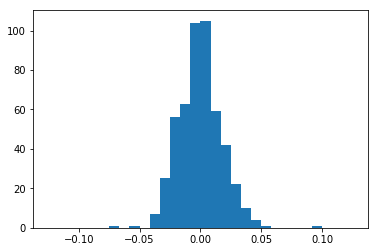

In [165]:
Y_pred = pd.Series(model.predict(X), index = A2.index)
Y_day = Y.resample('d').mean()
Y_day_pred = Y_pred.resample('d').mean()
dev = ((Y_day_pred - Y_day)/Y_day)
p,x,patches = plt.hist(dev, range=(-0.125,0.125), bins = 30)

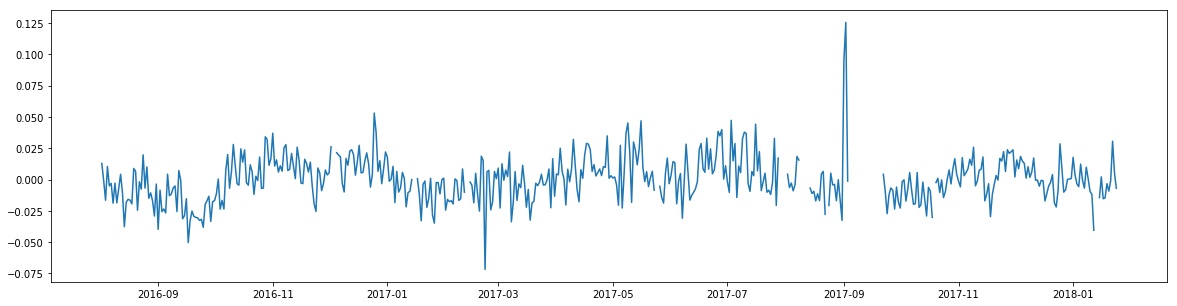

In [167]:
fig = plt.figure(figsize=(20,5))
plt.plot(dev)

### Compressor A4 disc trip (?)

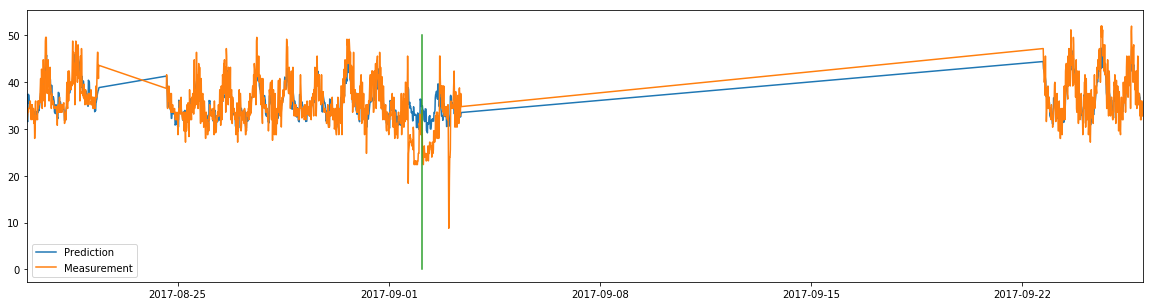

In [224]:
fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-08-20 00:00:00'), pd.to_datetime('2017-09-25 23:59:59'))
plt.plot((pd.to_datetime('2017-09-02 02:24:00'),pd.to_datetime('2017-09-02 02:24:00')), (0, 50))
#plt.plot((pd.to_datetime('2017-04-20 14:19:00'),pd.to_datetime('2017-04-20 14:19:00')),(0, 30))
plt.legend()

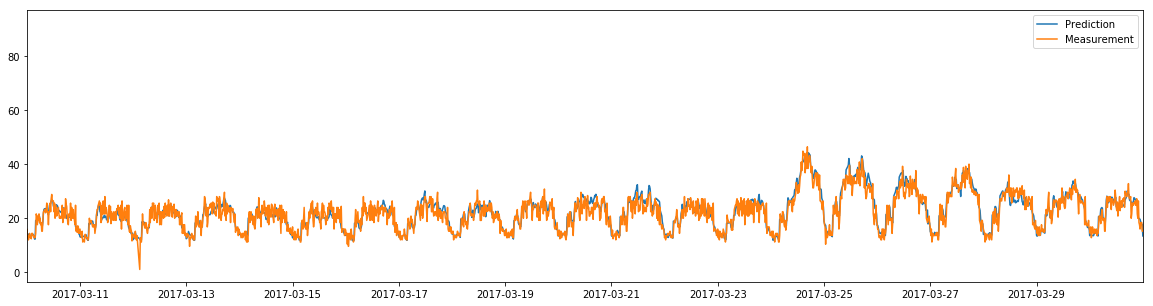

In [267]:
fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-03-10 00:00:00'), pd.to_datetime('2017-03-30 23:59:59'))

#plt.plot((pd.to_datetime('2017-04-20 14:19:00'),pd.to_datetime('2017-04-20 14:19:00')),(0, 30))
plt.legend()

## Compressor Rack B

In [209]:
Y = tmp['Rack B (kW)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.864003889926 MAPE:  0.1159392967691036


Usage date
2016-12-25    0.170359
2017-04-08    0.154187
2017-04-09    0.236115
2017-04-10    0.200243
2017-04-14    0.163763
2017-04-18    0.185681
2017-05-09    0.190973
2017-05-10    0.230694
2017-06-28    0.171405
dtype: float64

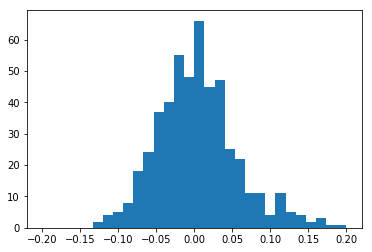

In [210]:
Y_pred = pd.Series(model.predict(X), index = A2.index)
Y_day = Y.resample('d').mean()
Y_day_pred = Y_pred.resample('d').mean()
dev = ((Y_day_pred - Y_day)/Y_day)
plt.hist(dev, range=(-0.2, 0.2), bins = 30)
dev[(dev>0.15)|(dev<-0.15)]

### Compressor B2 failure: Replaced oil sensor + Replace oil (?)

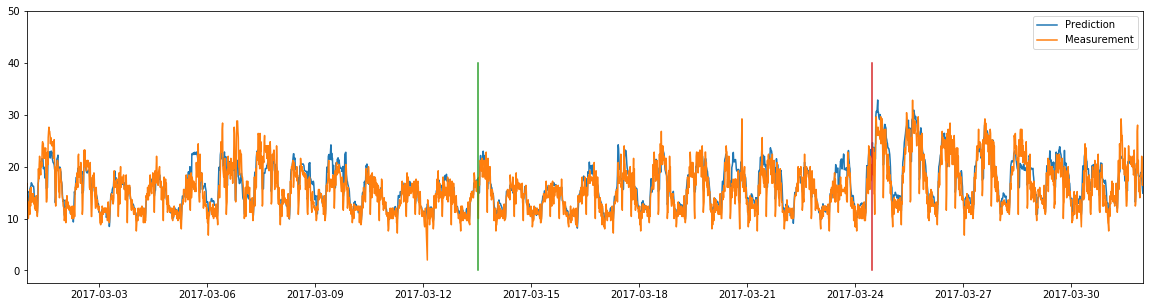

In [243]:
Y_pred = pd.Series(model.predict(X), index = A2.index)

fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-03-01 00:00:00'), pd.to_datetime('2017-03-31 23:59:59'))
plt.plot((pd.to_datetime('2017-03-13 12:58:00'),pd.to_datetime('2017-03-13 12:58:00')), (0, 40))
plt.plot((pd.to_datetime('2017-03-24 11:43:00'),pd.to_datetime('2017-03-24 11:43:00')),(0, 40))
plt.legend()

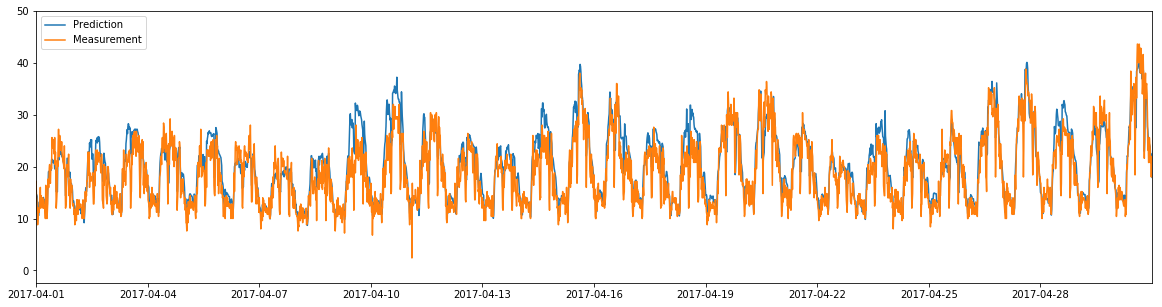

In [244]:
Y_pred = pd.Series(model.predict(X), index = A2.index)

fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-04-01 00:00:00'), pd.to_datetime('2017-04-30 23:59:59'))
plt.plot((pd.to_datetime('2017-03-13 12:58:00'),pd.to_datetime('2017-03-13 12:58:00')), (0, 40))
plt.plot((pd.to_datetime('2017-03-24 11:43:00'),pd.to_datetime('2017-03-24 11:43:00')),(0, 40))
plt.legend()

## Compressor Rack C

In [13]:
Y = tmp['Rack C (kW)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.917827467464 MAPE:  0.0978678934782119


Text(0,0.5,'Frequency')

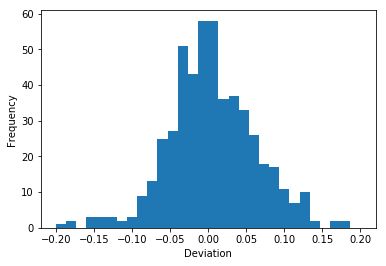

In [23]:
Y_pred = pd.Series(model.predict(X), index = A2.index)
Y_day = Y.resample('d').mean()
Y_day_pred = Y_pred.resample('d').mean()
dev = ((Y_day_pred - Y_day)/Y_day)
plt.hist(dev, range=(-0.2, 0.2), bins = 30)
dev[(dev>0.15)|(dev<-0.15)]
plt.xlabel('Deviation')
plt.ylabel('Frequency')

Text(0,0.5,'Power (kW)')

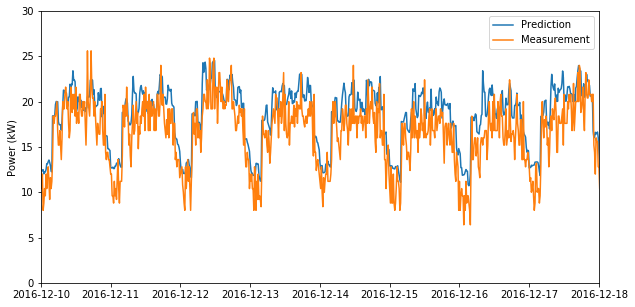

In [22]:
fig = plt.figure(figsize=(10,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2016-12-10 00:00:00'), pd.to_datetime('2016-12-18 00:00:00'))
plt.legend()
plt.ylim((0,30))
plt.ylabel('Power (kW)')

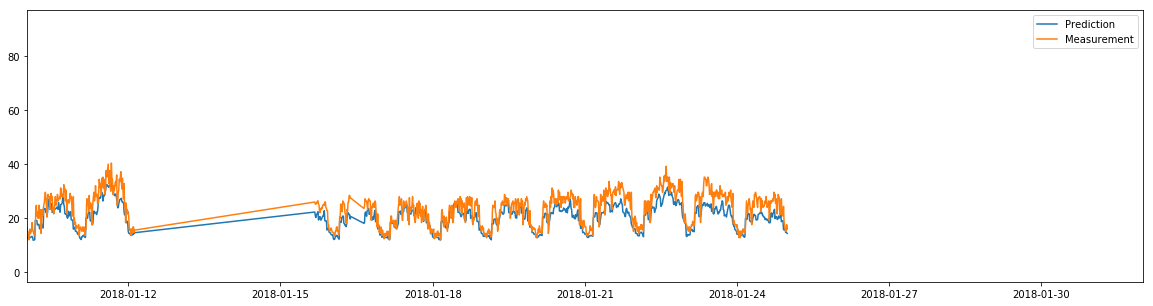

In [265]:
fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2018-01-10 00:00:00'), pd.to_datetime('2018-01-31 23:59:59'))
plt.legend()

## Compressor Rack D

In [226]:
Y = tmp['Rack D (kW)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.900822608034 MAPE:  0.06661212498876493


Usage date
2017-03-09    0.101315
2017-03-20    0.103208
2017-04-09    0.104033
2017-05-09    0.160504
2017-05-10    0.114216
dtype: float64

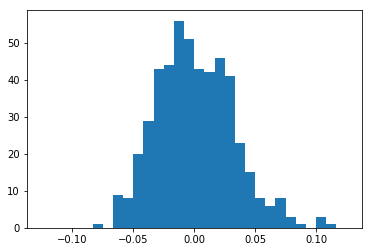

In [9]:
Y_pred = pd.Series(model.predict(X), index = A2.index)
Y_day = Y.resample('d').mean()
Y_day_pred = Y_pred.resample('d').mean()
dev = ((Y_day_pred - Y_day)/Y_day)
plt.hist(dev, range=(-0.125, 0.125), bins = 30)
dev = dev.abs()
dev[dev>0.1]

### Compressor D4 not running

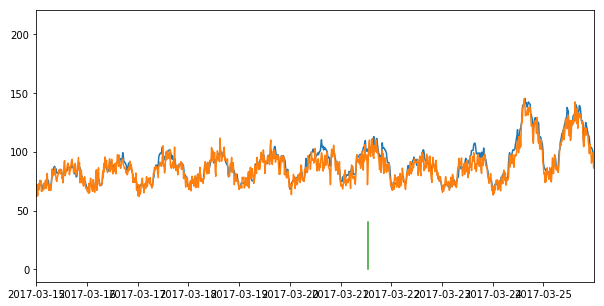

In [197]:
Y_pred = pd.Series(model.predict(X), index = A2.index)

fig = plt.figure(figsize=(10,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-03-15 00:00:00'), pd.to_datetime('2017-03-25 23:59:59'))
plt.plot((pd.to_datetime('2017-03-21 12:58:00'),pd.to_datetime('2017-03-21 12:58:00')), (0, 40))
#plt.legend()

### Low liquid level, added refrigerant

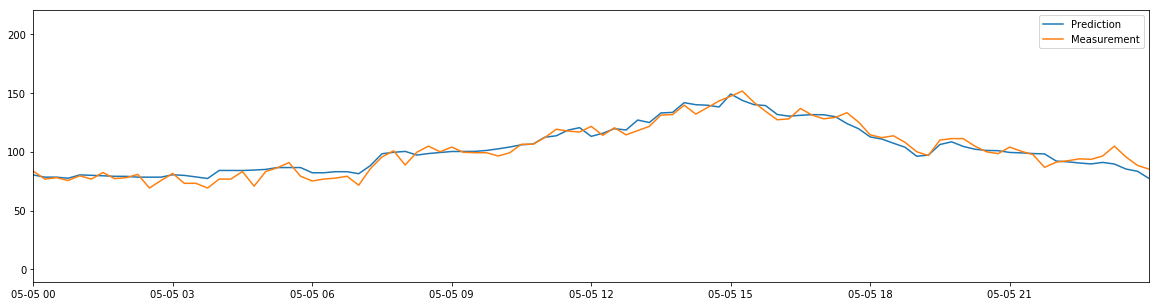

In [191]:
Y_pred = pd.Series(model.predict(X), index = A2.index)

fig = plt.figure(figsize=(20,5))
plt.plot(Y_pred, label = 'Prediction')
plt.plot(Y, label = 'Measurement')
plt.xlim(pd.to_datetime('2017-05-05 00:00:00'), pd.to_datetime('2017-05-05 23:59:59'))
plt.plot((pd.to_datetime('2017-05-08 09:43:00'),pd.to_datetime('2017-05-08 09:43:00')), (0, 40))
plt.plot((pd.to_datetime('2017-05-09 10:30:00'),pd.to_datetime('2017-05-09 10:30:00')), (0, 40))
plt.legend()

## Sum of all racks

In [179]:
Y = tmp['Rack A (kW)'] + tmp['Rack B (kW)'] + tmp['Rack C (kW)'] + tmp['Rack D (kW)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
model = MLPRegressor(hidden_layer_sizes=(25, ), activation='logistic', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(' R2: ', model.score(X_test, y_test),  'MAPE: ', np.mean(np.abs(y_test-y_pred)/y_test))

 R2:  0.935320284803 MAPE:  0.05125607522424811


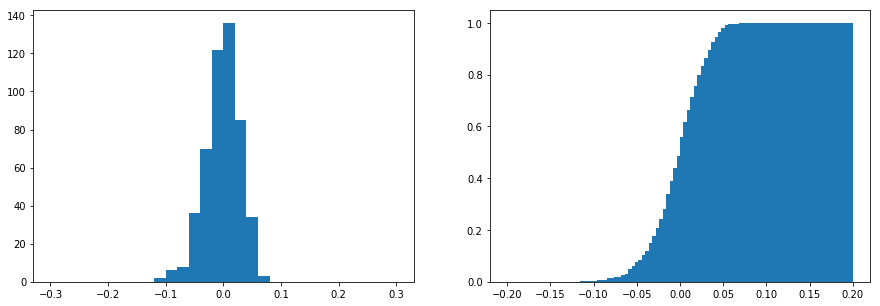

In [180]:
Y_pred = pd.Series(model.predict(X), index = A2.index)
Y_day = Y.resample('d').mean()
Y_day_pred = Y_pred.resample('d').mean()
dev = ((Y_day-Y_day_pred)/Y_day)
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
p,x,patches = plt.hist(dev, range = (-0.3, 0.3), bins = 30)

plt.subplot(1,2,2)
p,x,patches = plt.hist(dev, range = (-0.2, 0.2),  bins = 100, cumulative = True, normed = True)

#dev = dev.abs()
#dev[dev>0.1]

In [103]:
cdf = pd.DataFrame(x[0:100], index = p)

In [153]:
WO['Problem Type'].unique()

array(['PPM', 'Fan Issue/No Air Flow', 'Refrigeration Alarm', 'Too Warm',
       'Leaking Water', 'Gaskets/Seals', 'Too Cold', 'Making Noise',
       'Frozen-up', 'Lighting', 'Hinges/Handles/Knobs',
       'Shelving/Trim/Bumpers', 'Broken Glass/Damaged Door', 'Follow-up',
       'Route Maintenance', 'Steritech Issue', 'Drain Clogged',
       'Fire/Smoking/Odd Smell'], dtype=object)

In [155]:
WO = pd.read_excel('/Users/chenbq/Desktop/CMU/Research 101/Vapour Compression/Giant Eagle/Work Order 0045.xlsx', header  =6)
WO = WO[WO['Asset Category'] == 'Refrigeration']

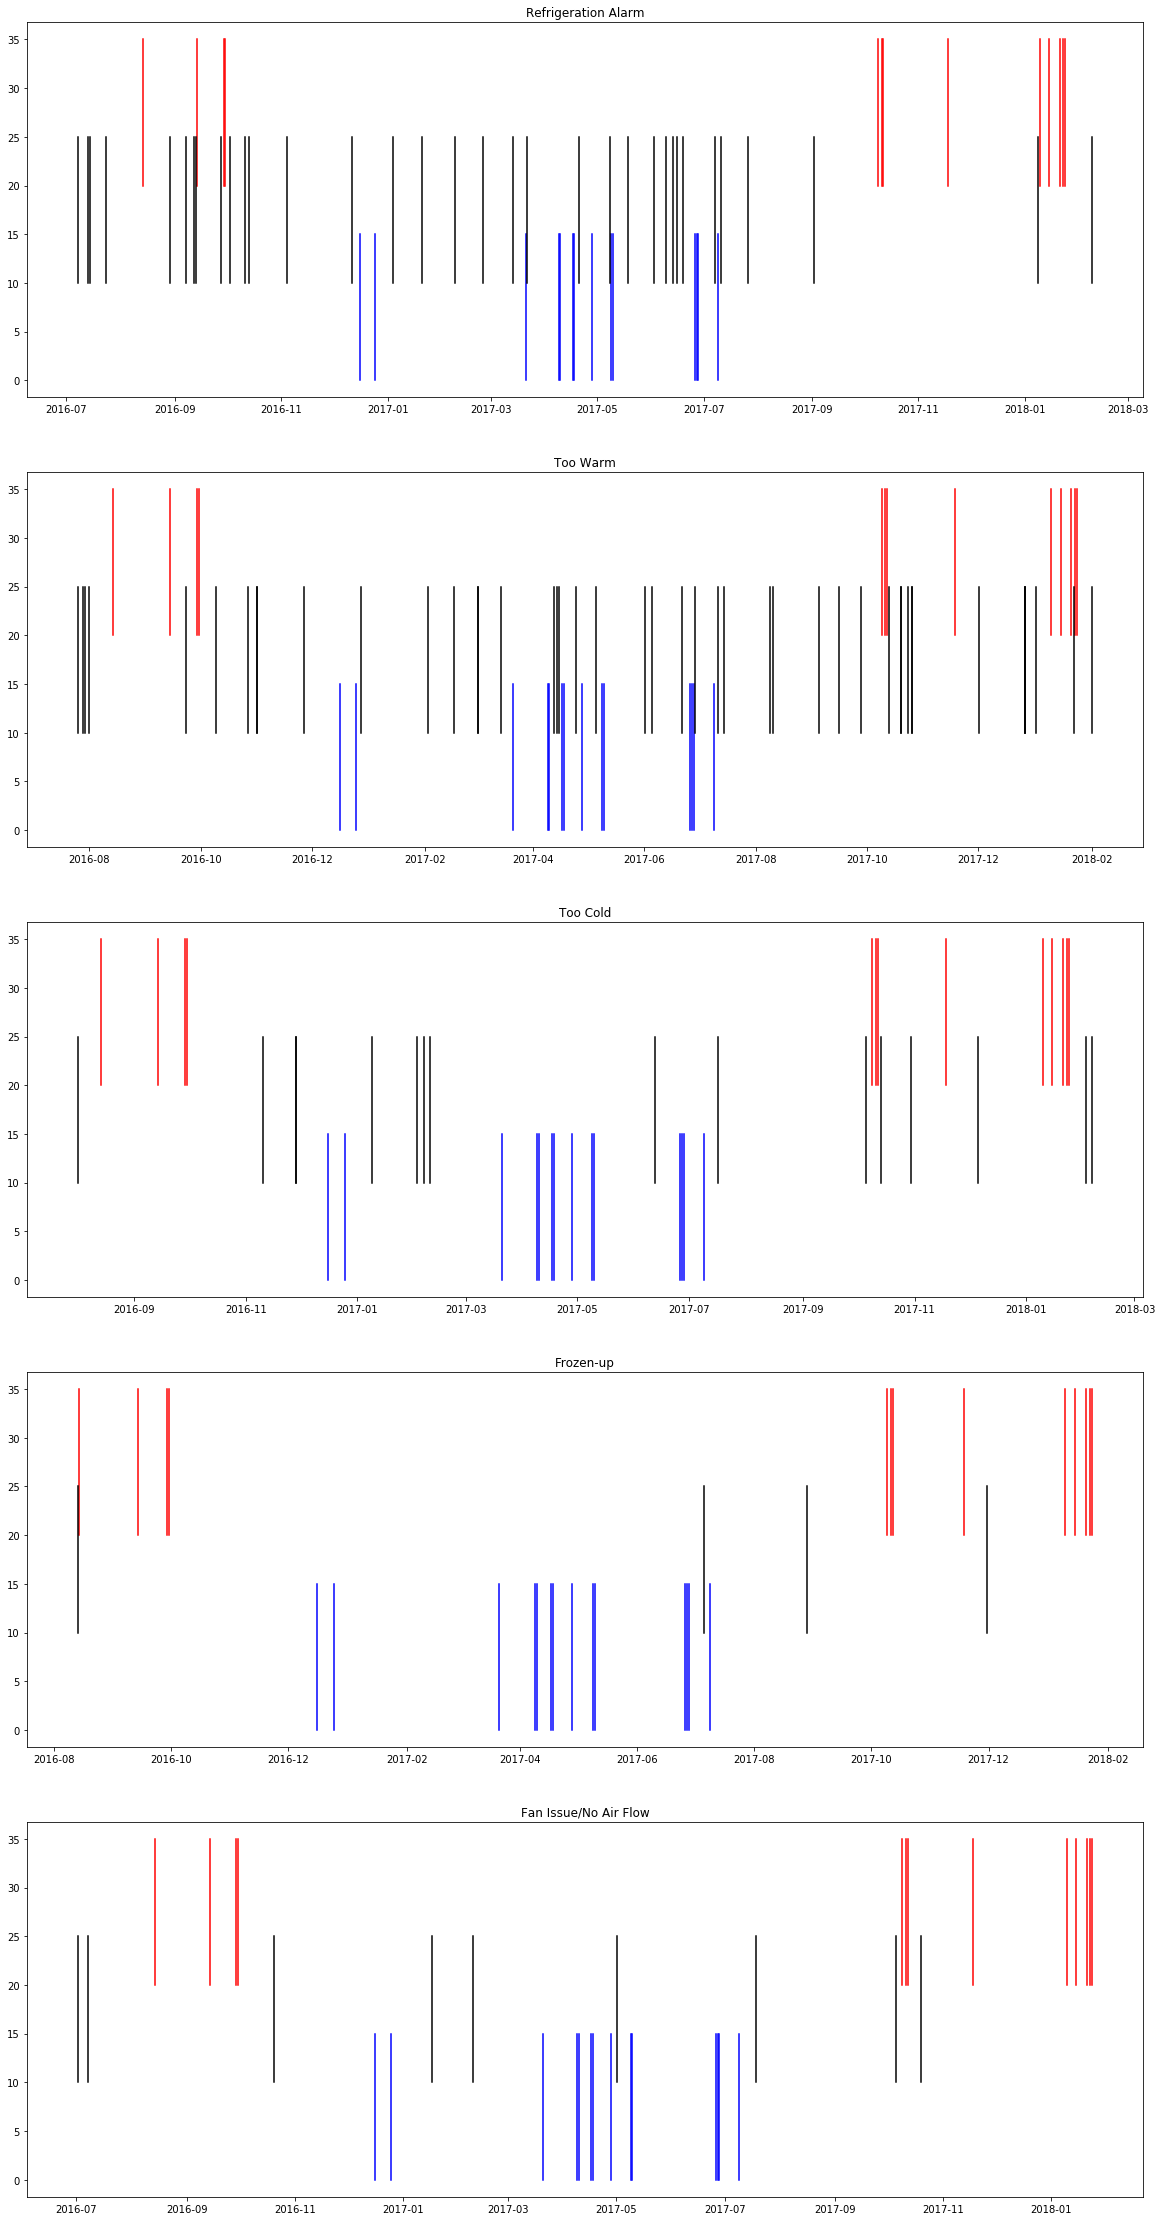

In [160]:
pl = ['Refrigeration Alarm', 'Too Warm', 'Too Cold', 'Frozen-up', 'Fan Issue/No Air Flow']
fig = plt.figure(figsize=(20,40))
for j, problem in enumerate(pl):
    plt.subplot(len(pl),1,j+1)
    WO_tmp = WO[WO['Problem Type'] == problem]

    for i, d in enumerate(s.index):
        plt.plot((d,d), (0, 15), c='b', label = 'Below prediction')
    
    for i, d in enumerate(l.index):
        plt.plot((d,d), (20, 35), c='r', label = 'Above prediction')
    
    for i in range(len(WO_tmp)):
        plt.plot((WO_tmp['WO Created on'].iloc[i], WO_tmp['WO Created on'].iloc[i]),(10, 25), c='k', label = 'WO')

    plt.title(problem)

Text(0.5,1,'Refrigeration Leakage')

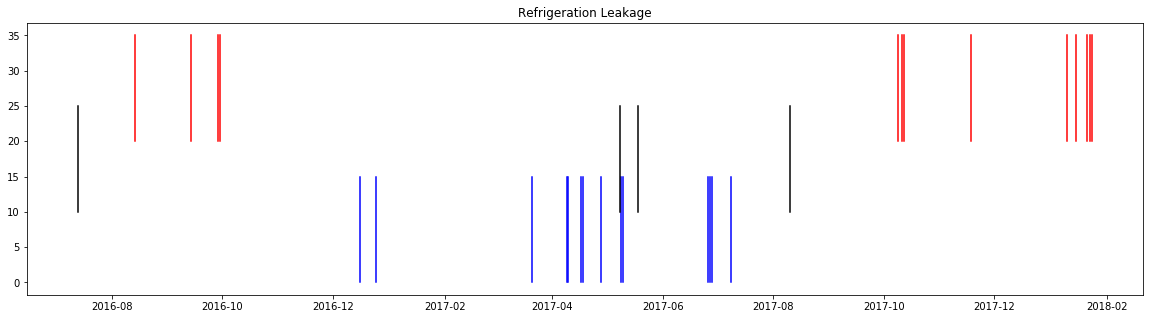

In [162]:
fig = plt.figure(figsize=(20,5))
for i, d in enumerate(s.index):
    plt.plot((d,d), (0, 15), c='b', label = 'Below prediction')
    
for i, d in enumerate(l.index):
    plt.plot((d,d), (20, 35), c='r', label = 'Above prediction')
    
for i in range(len(rl)):
    plt.plot((rl['WO Created on'].iloc[i], rl['WO Created on'].iloc[i]),(10, 25), c='k', label = 'WO')

#plt.legend()
    
plt.title('Refrigeration Leakage')

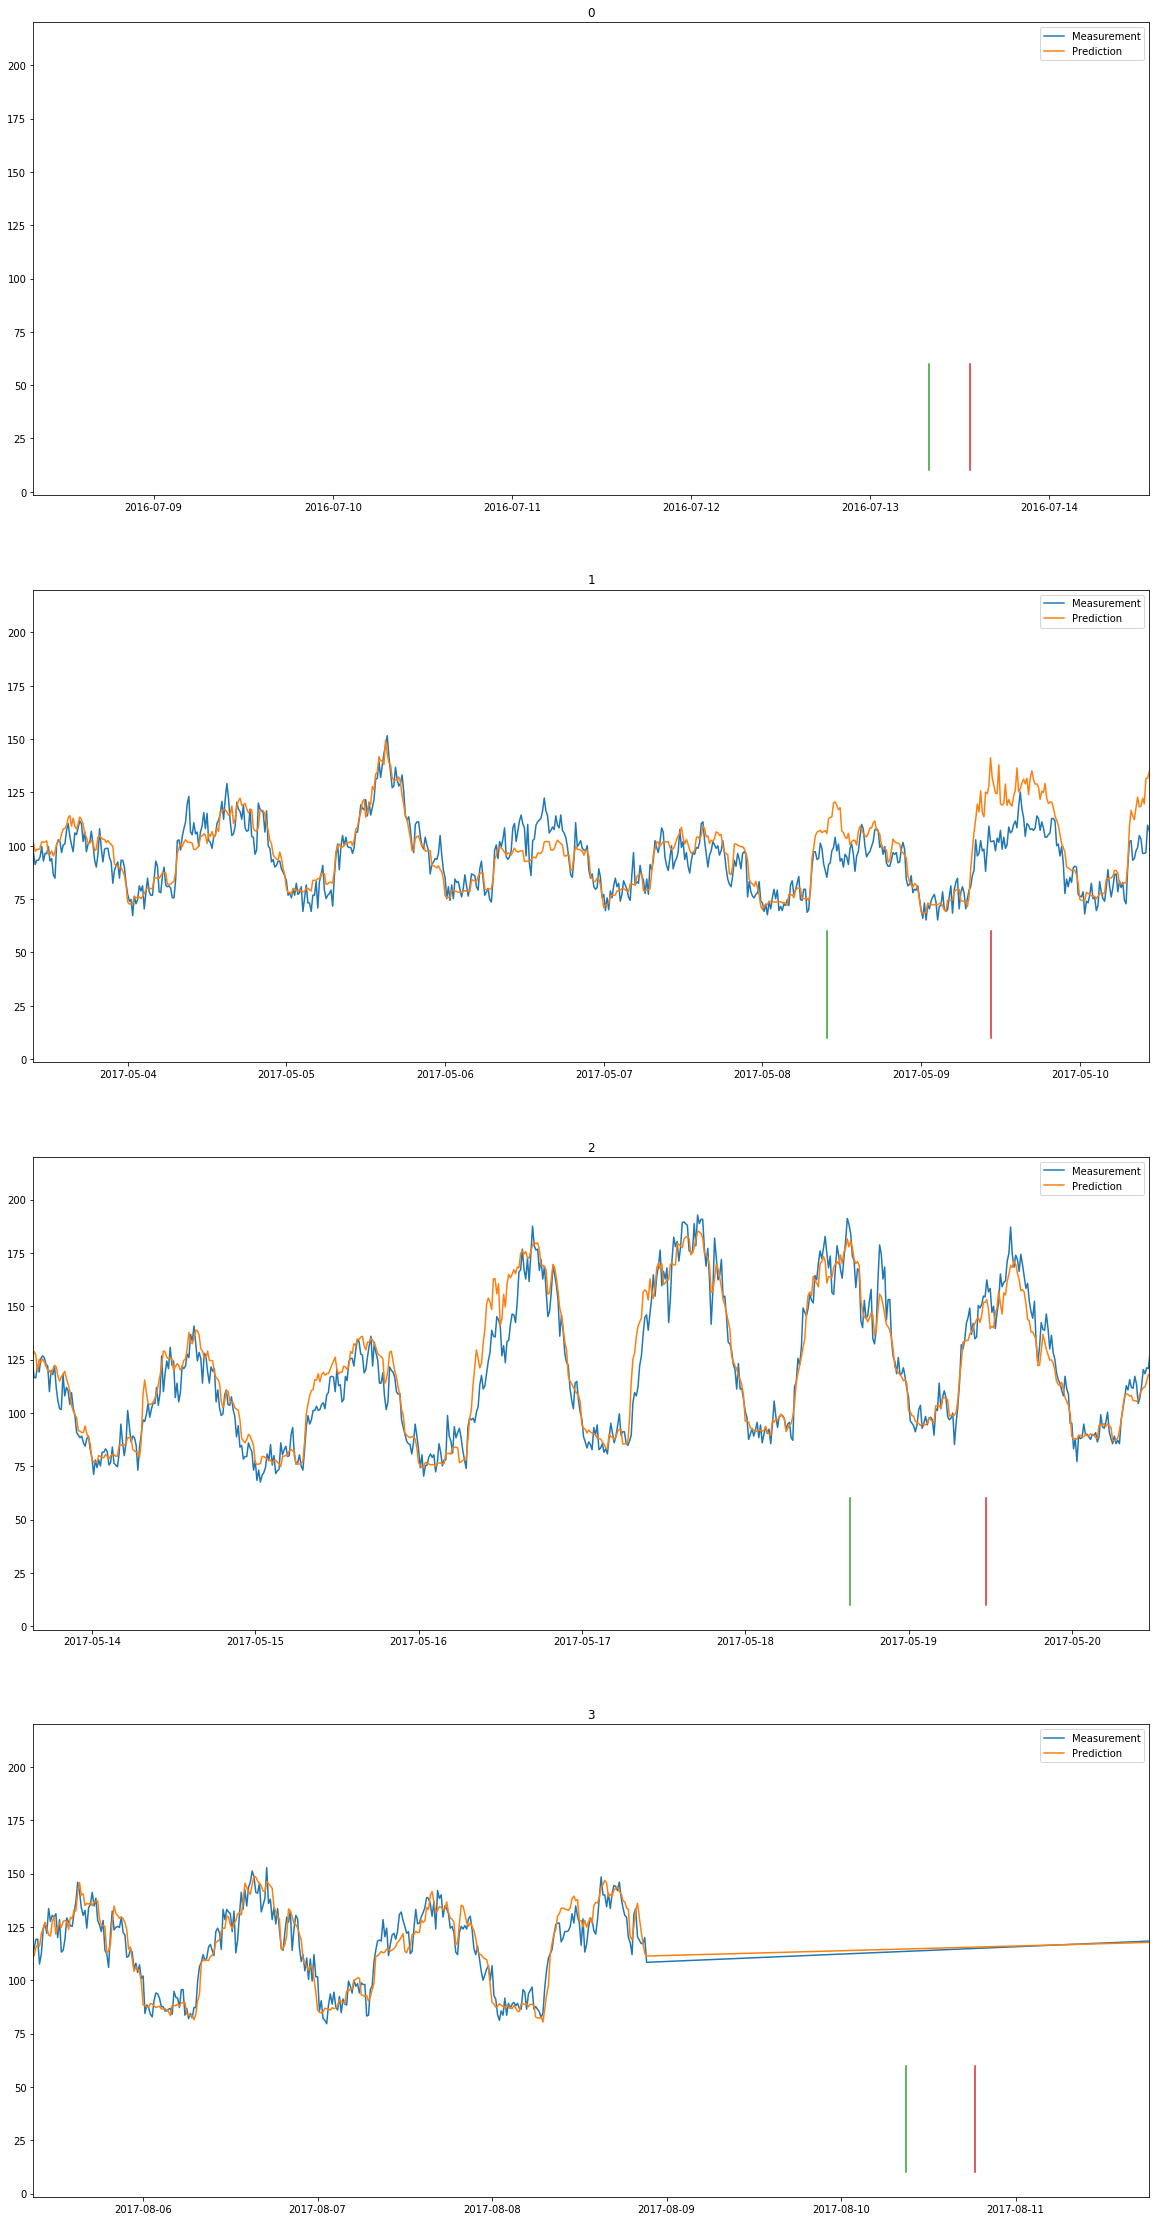

In [97]:
fig = plt.figure(figsize=(20,40))
for i in range(len(rl)):
    plt.subplot(len(rl), 1, i+1)
    plt.plot(Y, label = 'Measurement')
    plt.plot(Y_pred, label = 'Prediction')
    plt.xlim(rl['WO Created on'].iloc[i] - datetime.timedelta(days=5), rl['WO Completed On'].iloc[i]+ datetime.timedelta(days=1))
    plt.plot((rl['WO Created on'].iloc[i],rl['WO Created on'].iloc[i]),(10, 60))
    plt.plot((rl['WO Completed On'].iloc[i],rl['WO Completed On'].iloc[i]),(10, 60))
    plt.legend()
    plt.title(i)

(Notation: 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday)


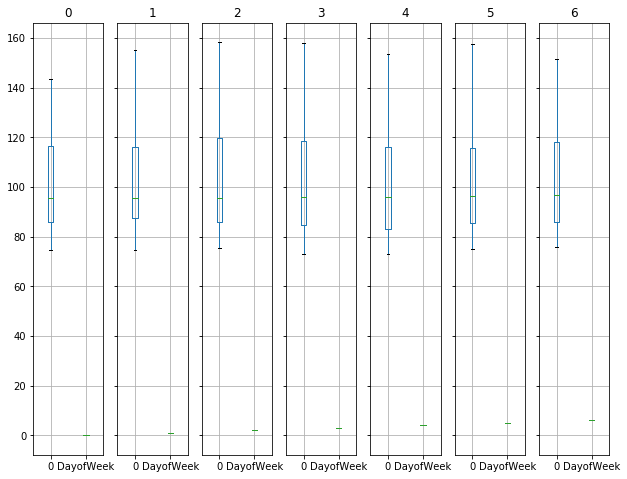

In [190]:
Y_day = pd.DataFrame(Y_day)
Y_day = Y_day.assign(DayofWeek = pd.Series([date.weekday() for date in Y_day.index], index=Y_day.index)) 

Y_day.groupby('DayofWeek').boxplot(figsize=(10,8),layout=(1,7))
print("(Notation: 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday)")